# DL vertex finding network training

This notebook is designed to take the input and truth images generated by the <code>make_images.ipynb</code> notebook and train networks for vertex finding. This notebook generates models for each of the U, V and W views for each of the required passes.
    
Most of the cells below will not need any editing, but towards the bottom of the notebook you will find some additional markdown that describes what you may need to edit (essentially just some file locations).

In [1]:
# Automatically reload external libraries that change
%reload_ext autoreload
%autoreload 2

# If a matplotlib plot command is issued, display the results in the notebook
%matplotlib inline

In [2]:
# imaging.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


def imagify(input, pred, truth, n=3, randomize=True, null_code=0):
    """Process input, prediction and mask data ready for display
    
    Args:
        inputs: Input tensor from a batch
        predictions: Predictions tensor from a batch
        truth: Truth tensor from a batch
        n: The number of images to extract from the batch (default: 3)
        randomize: Choose random images from the batch if True, choose the first n otherwise (default: True)
        null_code: The null mask code (default: 0)
            
    Returns:
        A tuple (if n == 1) or zip of the processed images ready for display.
    """
    # Select the images to process
    choices = np.random.choice(np.array(range(inputs.shape[0])), size=n) if randomize else np.array(range(n))
    input_imgs = input[choices,0,...]
    truth_imgs = truth[choices,...]

    input_imgs = input_imgs.detach().cpu()
    truth_imgs = truth_imgs.detach().cpu()
    pred_imgs = pred[choices,...].detach().cpu()

    # Remove non-hit regions
    mask = truth_imgs == null_code
    pred_imgs = np.argmax(pred_imgs, axis=1)
    pred_imgs = np.ma.array(pred_imgs, mask = mask).filled(0)

    return zip(input_imgs, truth_imgs, pred_imgs) if n > 1 else (input_imgs, truth_imgs, pred_imgs)


def show_batch(epoch, batch, input, pred, truth, null_code=0, n=3, randomize=True):
    """Display the images for a given epoch and batch. Each row is a triplet of input, prediction and mask.

    Args:
        epoch: The current training epoch
        batch: The current training batch
        input: Input tensor from a batch
        pred: Predictions tensor from a batch
        truth: Truth tensor from a batch
        n: The number of images to extract from the batch (default: 3)
        randomize: Choose random images from the batch if True, choose the first n otherwise (default: True)
        null_code: The null mask code (default: 0).
    """
    global vertex_pass, view
    ax = None
    rows, cols, size = 1, 2, 9

    images = imagify(input, pred, truth, n, randomize, null_code)

    for i, imgs in enumerate(images):
        raw, cls, net = imgs
        pair = (cls, net)
        fig, axs = plt.subplots(1, cols, figsize=(cols * size, size))
        for img, ax in zip(pair, axs):
            ax.imshow(img, cmap="magma", interpolation='nearest')
            ax.axis('off')
        plt.tight_layout()
        save_figure(plt, f"outputs/images/pass{vertex_pass}/{view}/output_{epoch}_{batch}_{i}")
        plt.close(fig)


def save_figure(fig, name):
    """Output a matplotlib figure PNG, PDF and EPS formats.

    Args:
        fig (Figure): The matplotlib figure to save.
        name (str): The output filename excluding extension.
    """
    fig.savefig(name + ".png", facecolor='w')
    fig.savefig(name + ".pdf")
    #fig.savefig(name + ".eps")


def get_supported_formats():
    """Retrieve the supported image formats.

    Returns:
        A dictionary containing strings of file format descriptions keyed by extension.
    """
    return plt.gcf().canvas.get_supported_filetypes()

In [3]:
# analysis.py
from functools import partial

def flatten_model(module):
    children = list(module.children())
    if len(children) == 0:
        return [module]
    else:
        flat_model = []
        for child in children:
            flat_model += flatten_model(child)
        return flat_model


class Hook:
    def __init__(self, id, module, func):
        self.id = id
        self.name = module.__class__.__name__
        self.hook = module.register_forward_hook(partial(func, self))
    
    def remove(self):
        self.hook.remove()
    
    def __del__(self):
        self.remove()


def append_stats(hook, module, input, output):
    if not module.training:
        return
    if not hasattr(hook, 'stats'):
        hook.stats = ([],[],[])
    means, stds, hists = hook.stats
    means.append(output.data.mean())
    stds.append(output.data.std())
    hists.append(output.data.histc(40, -5, 5))

In [4]:
# model.py

import torch.nn as nn
import torch


def maxpool():
    """Return a max pooling layer.
    
        The maxpooling layer has a kernel size of 2, a stride of 2 and no padding.

        Returns:
            The max pooling layer
    """
    return nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)


def dropout(prob):
    """Return a dropout layer.

        Args:
            prob: The probability that drop out will be applied.

        Returns:
            The dropout layer
    """
    return nn.Dropout(prob)


def reinit_layer(layer, leak = 0.0, use_kaiming_normal=True):
    """Reinitialises convolutional layer weights.
    
        The default Kaiming initialisation in PyTorch is not optimal, this method
        reinitialises the layers using better parameters

        Args:
            seq_block: The layer to be reinitialised.
            leak: The leakiness of ReLU (default: 0.0)
            use_kaiming_normal: Use Kaiming normal if True, Kaiming uniform otherwise (default: True)
    """
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
        if use_kaiming_normal:
            nn.init.kaiming_normal_(layer.weight, a = leak)
        else:
            nn.init.kaiming_uniform_(layer.weight, a = leak)
            layer.bias.data.zero_()


class ConvBlock(nn.Module):
    """A convolution block
    """
    
    # Sigmoid activation suitable for binary cross-entropy
    def __init__(self, c_in, c_out, k_size = 3, k_pad = 1):
        """Constructor.

            Args:
                c_in: The number of input channels
                c_out: The number of output channels
                k_size: The size of the convolution filter
                k_pad: The amount of padding around the images
        """
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(c_in, c_out, kernel_size = k_size, padding = k_pad, stride = 1)
        self.norm1 = nn.GroupNorm(8, c_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(c_out, c_out, kernel_size = k_size, padding = k_pad, stride = 1)
        self.norm2 = nn.GroupNorm(8, c_out)
        self.identity = nn.Conv2d(c_in, c_out, kernel_size = 1, padding = 0, stride = 1)
        reinit_layer(self.conv1)
        reinit_layer(self.conv2)

    def forward(self, x):
        """Forward pass.
        
            Args:
                x: The input to the layer
                
            Returns:
                The output from the layer
        """
        identity = self.identity(x)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        return self.relu(x + identity)


class TransposeConvBlock(nn.Module):
    """A tranpose convolution block
    """
    
    def __init__(self, c_in, c_out, k_size = 3, k_pad = 1):
        """Constructor.

            Args:
                c_in: The number of input channels
                c_out: The number of output channels
                k_size: The size of the convolution filter
                k_pad: The amount of padding around the images
        """
        super(TransposeConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(c_in, c_out, kernel_size = k_size, padding = k_pad, output_padding = 1, stride = 2),
            nn.GroupNorm(8, c_out),
            nn.ReLU(inplace=True))
        reinit_layer(self.block[0])

    def forward(self, x):
        """Forward pass.
        
            Args:
                x: The input to the layer
                
            Returns:
                The output from the layer
        """
        return self.block(x)

class Sigmoid(nn.Module):
    """A sigmoid activation function that supports categorical cross-entropy
    """
    
    def __init__(self, out_range = None):
        """Constructor.

            Args:
                out_range: A tuple covering the minimum and maximum values to map to
        """
        super(Sigmoid, self).__init__()
        if out_range is not None:
            self.low, self.high = out_range
            self.range = self.high - self.low
        else:
            self.low = None
            self.high = None
            self.range = None
    
    def forward(self, x):
        """Applies the sigmoid function.
        
            Rescales to the specified range if provided during construction
        
            Args:
                x: The input to the layer
                
            Returns:
                The (potentially scaled) sigmoid of the input
        """
        if self.low is not None:
            return torch.sigmoid(x) * (self.range) + self.low
        else:
            return torch.sigmoid(x)

class UNet(nn.Module):
    """A U-Net for semantic segmentation.
    """
    
    def __init__(self, in_dim, n_classes, depth = 4, n_filters = 16, drop_prob = 0.1, y_range = None):
        """Constructor.

            Args:
                in_dim: The number of input channels
                n_classes: The number of classes
                depth: The number of convolution blocks in the downsampling and upsampling arms of the U (default: 4)
                n_filters: The number of filters in the first layer (doubles for each downsample) (default: 16)
                drop_prob: The dropout probability for each layer (default: 0.1)
                y_range: The range of values (low, high) to map to in the output (default: None)
        """
        super(UNet, self).__init__()
        # Contracting Path
        self.ds_conv_1 = ConvBlock(in_dim, n_filters)
        self.ds_conv_2 = ConvBlock(n_filters, 2 * n_filters)
        self.ds_conv_3 = ConvBlock(2 * n_filters, 4 * n_filters)
        self.ds_conv_4 = ConvBlock(4 * n_filters, 8 * n_filters)

        self.ds_maxpool_1 = maxpool()
        self.ds_maxpool_2 = maxpool()
        self.ds_maxpool_3 = maxpool()
        self.ds_maxpool_4 = maxpool()
        
        self.ds_dropout_1 = dropout(drop_prob)
        self.ds_dropout_2 = dropout(drop_prob)
        self.ds_dropout_3 = dropout(drop_prob)
        self.ds_dropout_4 = dropout(drop_prob)
        
        self.bridge = ConvBlock(8 * n_filters, 16 * n_filters)
        
        # Expansive Path
        self.us_tconv_4 = TransposeConvBlock(16 * n_filters, 8 * n_filters)
        self.us_tconv_3 = TransposeConvBlock(8 * n_filters, 4 * n_filters)
        self.us_tconv_2 = TransposeConvBlock(4 * n_filters, 2 * n_filters)
        self.us_tconv_1 = TransposeConvBlock(2 * n_filters, n_filters)

        self.us_conv_4 = ConvBlock(16 * n_filters, 8 * n_filters)
        self.us_conv_3 = ConvBlock(8 * n_filters, 4 * n_filters)
        self.us_conv_2 = ConvBlock(4 * n_filters, 2 * n_filters)
        self.us_conv_1 = ConvBlock(2 * n_filters, 1 * n_filters)

        self.us_dropout_4 = dropout(drop_prob)
        self.us_dropout_3 = dropout(drop_prob)
        self.us_dropout_2 = dropout(drop_prob)
        self.us_dropout_1 = dropout(drop_prob)

        self.output = nn.Sequential(nn.Conv2d(n_filters, n_classes, 1), Sigmoid(y_range))

    def forward(self, x):
        """Forward pass.
        
            Args:
                x: The input to the layer
                
            Returns:
                The output from the layer
        """
        res = x

        # Downsample
        res = self.ds_conv_1(res); conv_stack_1 = res.clone()
        res = self.ds_maxpool_1(res)
        res = self.ds_dropout_1(res)
        
        res = self.ds_conv_2(res); conv_stack_2 = res.clone()
        res = self.ds_maxpool_2(res)
        res = self.ds_dropout_2(res)
        
        res = self.ds_conv_3(res); conv_stack_3 = res.clone()
        res = self.ds_maxpool_3(res)
        res = self.ds_dropout_3(res)
        
        res = self.ds_conv_4(res); conv_stack_4 = res.clone()
        res = self.ds_maxpool_4(res)
        res = self.ds_dropout_4(res)
        
        # Bridge
        res = self.bridge(res)
        
        # Upsample
        res = self.us_tconv_4(res)
        res = torch.cat([res, conv_stack_4], dim=1)
        res = self.us_dropout_4(res)
        res = self.us_conv_4(res)

        res = self.us_tconv_3(res)
        res = torch.cat([res, conv_stack_3], dim=1)
        res = self.us_dropout_3(res)
        res = self.us_conv_3(res)
        
        res = self.us_tconv_2(res)
        res = torch.cat([res, conv_stack_2], dim=1)
        res = self.us_dropout_2(res)
        res = self.us_conv_2(res)
        
        res = self.us_tconv_1(res)
        res = torch.cat([res, conv_stack_1], dim=1)
        res = self.us_dropout_1(res)
        res = self.us_conv_1(res)
        
        output = self.output(res)

        return output

In [5]:
# network.py

# from model import *

import numpy as np
import torch
import torch.optim as opt


def set_seed(seed):
    """Set the various seeds and flags to ensure deterministic performance
    
        Args:
            seed: The random seed
    """
    torch.backends.cudnn.deterministic = True   # Note, can impede performance
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)


def get_class_weights(stats):
    """Get the weights for each class
    
        Each class has a weight inversely proportional to the number of instances in the training set
    
        Args:
            stats: The number of instances of each class
        
        Returns:
            The weights for each class
    """
    if np.any(stats == 0.):
        print("Found a class that doesn't appear")
        idx = np.where(stats == 0.)
        stats[idx] = 1
        weights = 1. / stats
        weights[idx] = 0
    else:
        weights = 1. / stats
    return [weight / sum(weights) for weight in weights]


def load_model_only(filename, num_classes, device):
    """Load a model

        Args:
            filename: The name of the file with the pretrained model parameters
            num_classes: The number of classes available to predict
            weights: The weights to apply to the classes
            device: The device on which to run

        Returns:
            A tuple composed (in order) of the model, loss function, and optimiser
    """
    model = UNet(1, n_classes = num_classes, depth = 4, n_filters = 16, y_range = (0, num_classes))
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()
    return model


def load_model(filename, num_classes, weights, device):
    """Load a model

        Args:
            filename: The name of the file with the pretrained model parameters
            num_classes: The number of classes available to predict
            weights: The weights to apply to the classes
            device: The device on which to run

        Returns:
            A tuple composed (in order) of the model, loss function, and optimiser
    """
    model = UNet(1, n_classes = num_classes, depth = 4, n_filters = 16, y_range = (0, num_classes))
    model.load_state_dict(torch.load(filename, map_location=device))
    model.eval()
    loss_fn = nn.CrossEntropyLoss(torch.as_tensor(weights, device=device, dtype=torch.float))
    optim = opt.Adam(model.parameters())
    return model, loss_fn, optim


def save_model(model, input, filename):
    """Save the model
    
        The model is saved as both a pkl file and a TorchScript pt file, which can be loaded via
            model.load_state_dict(torch.load(PATH))
            model.eval()
        
        Args:
            model: The model to save
            input: An example input to the model
            filename: The output filename, without file extension
    """
    torch.save(model.state_dict(), f"{filename}.pkl")

    
def accuracy(pred, truth, nearby=False):
    """Get the network accuracy
    
        Args:
            pred: The network prediction
            truth: The true class
            nearby: Whether to consider adjacent classes acceptable
        
        Returns:
            The accuracy
    """
    target = truth.squeeze(1)
    pred_cls = pred.argmax(dim=1)
    mask = (target != 0)
    if nearby:
        result = abs(pred_cls[mask] - target[mask]) <= 1
    else:
        result = pred_cls[mask] == target[mask]
    return result.float().mean()


def create_model(num_classes, weights, device):
    """Create the model

        Args:
            num_classes: The number of classes available to predict
            weights: The weights to apply to the classes
            device: The device on which to run

        Returns:
            A tuple composed (in order) of the model, loss function, and optimiser
    """
    model = UNet(1, n_classes = num_classes, depth = 4, n_filters = 16, y_range = (0, num_classes - 1))
    loss_fn = nn.CrossEntropyLoss(torch.as_tensor(weights, device=device, dtype=torch.float))
    optim = opt.Adam(model.parameters())
    return model, loss_fn, optim


In [6]:
# data.py

import numpy as np
import torch
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class SegmentationDataset(Dataset):
    """Dataset suitable for segmentation tasks.
    """

    def __init__(self, image_dir, mask_dir, filenames, transform=False, device=torch.device('cuda:0')):
        """Constructor.

            Args:
                image_dir: The directory containing the images
                mask_dir: The directory containing the masks
                filenames: The filanems for the images associate with this dataset
                transform: Whether or not to transform the items (default: False).
                device: The device on which tensors should be created (default: 'cuda:0')
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.filenames = filenames
        self.device = device


    def __len__(self):
        """Retrieve the number of samples in the dataset.
        
            Returns:
                The number of samples in the dataset
        """
        return len(self.filenames)


    def __getitem__(self, idx):
        """Retrieve a sample from the dataset.
        
            Args:
                idx: The index of the sample to be retrieved
        
            Returns:
                The sample requested
        """
        img_name = os.path.join(self.image_dir, self.filenames[idx])
        with open(img_name, 'rb') as file:
            image = np.load(file)['arr_0']
        
        mask_name = os.path.join(self.mask_dir, self.filenames[idx])
        with open(mask_name, 'rb') as file:
            mask = np.load(file)['arr_0']
                
        image = torch.as_tensor(np.expand_dims(image, axis=0), device=self.device, dtype=torch.float)
        mask = torch.as_tensor(mask, device=self.device, dtype=torch.long)
        
        if self.transform:
            should_hflip = True if torch.rand(1) > 0.5 else False
            should_vflip = True if torch.rand(1) > 0.5 else False
            should_transpose = True if torch.rand(1) > 0.5 else False
            # need to check that these make sense in the context of pixel classification
            if should_hflip:
                image = tv.transforms.functional.hflip(image)
                mask = tv.transforms.functional.hflip(mask)
            if should_vflip:
                image = tv.transforms.functional.vflip(image)
                mask = tv.transforms.functional.vflip(mask)
            if should_transpose:
                image = image.transpose(1, 2)
                mask = mask.transpose(1, 2)
        
        return (image, mask)


class SegmentationBunch():
    """Associates batches of training, validation and testing datasets suitable
        for segmentation tasks.
    """
    
    def __init__(self, root_dir, image_dir, mask_dir, batch_size, train_pct=None, valid_pct=0.1,
                 test_pct=0.0, transform=False, device=torch.device('cuda:0')):
        """Constructor.

            Args:
                root_dir: The top-level directory containing the images
                image_dir: The relative directory containing the images
                mask_dir: The relative directory containing the masks
                batch_size: The batch size
                valid_pct: The fraction of images to be used for validation (default: 0.1)
                test_pct: The fraction of images to be used for testing (default: 0.0)
                transform: Whether or not to transform the items (default: False)
                device: The device on which tensors should be created (default: 'cuda:0')
        """
        assert((valid_pct + test_pct) < 1.)
        image_dir = os.path.join(root_dir, image_dir)
        mask_dir = os.path.join(root_dir, mask_dir)
        image_filenames = np.array(next(os.walk(image_dir))[2])
        print(image_filenames)
        n_files = len(image_filenames)
        valid_size = int(n_files * valid_pct)
        train_size = n_files - valid_size if train_pct is None else int(n_files * train_pct)
        
        sample = np.random.permutation(n_files)
        train_sample = sample[valid_size:] if not train_size else \
            sample[valid_size:valid_size + train_size]
        valid_sample = sample[:valid_size]
                
        train_ds = SegmentationDataset(image_dir, mask_dir, image_filenames[train_sample], transform, device)
        self.train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)
        
        valid_ds = SegmentationDataset(image_dir, mask_dir, image_filenames[valid_sample], None, device)
        self.valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)


    def count_classes(self, num_classes):
        """Count the number of instances of each class in the training set
        
            Args:
                num_classes: The number of classes in the training set
                
            Returns:
                A list of the number of instances of each class
        """
        count = np.zeros(num_classes)
        for batch in self.train_dl:
            _, truth = batch
            unique, counts = torch.unique(truth, return_counts=True)
            unique = [ u.item() for u in unique ]
            counts = [ c.item() for c in counts ]
            this_dict = dict(zip(unique, counts))
            for key in this_dict:
                count[key] += this_dict[key]
        return count

# Run network training here

The key parameters that will need editing are the view and the pass to be trained. Each view/pass combination has its own network. Views are specified using the standard U, V, W nomenclature (and is consistent with the file naming conventions from previous steps), while the pass is either pass 1 or pass 2.

The respective variables can be set in the cell below via <code>view</code> and <code>vertex_pass</code>.

If you edited the <code>thresholds</code> variable at the <code>make_images</code> stage, you may need to update the <code>NUM_CLASSES</code> variable to reflect any change in the number of thresholds. Note that this value should be equal to the length of the <code>thresholds</code> variable, despite this variable specifying bin edges, because one extra class is required to represent the null case where a pixel has no hits in it.

<code>batch_size</code> can, of course, be varied according to the available resources of your GPU, but as a semantic segmentation network you'll need a lot of memory on your GPU to increase this beyond the current default of 32.

The <code>image_path</code> variable should contain the path to the images generated by the <code>make_images</code> notebook (i.e. <code>global_path</code>), and will expect to find the <code>Hits</code> and <code>Truth</code> folders within that path).

Note that the cells below will count the class representation in the training set, determine how to weight them and print this out. It's worth taking a look at this output to ensure all classes are represented, as training will fail if they are not.

You will want to set the number of epochs, <code>n_epochs</code> to train for. This is not easy to determine a priori, but 20 is a reasonable starting point (plots of the loss function and accuracy are produced to help you determine when the network has effectively trained).

<code>model_name</code> acts as a prefix for saving the model. The state of the model is saved after every epoch, with a suffix indicating the epoch number.

Once you are happy with the variable values you can run all of the cells in this section in order (having run all of the cells above), with the final cell in this section actually performing the training.

In [7]:
# This line is important for GPU running, otherwise some weights end up on the CPU
torch.set_default_tensor_type(torch.cuda.FloatTensor)

view = "W"
vertex_pass = 1
the_seed = 42
gpu = torch.device('cuda:0')
batch_size=32
NUM_CLASSES = 20   # NULL = 0, various distance bands 1-19
image_path = f"Accel/Pass{vertex_pass}/Images{view}"
n_epochs = 25
model_name = "dunefd_hd_accel"

for subdir in ["models", "stats", "images"]:
    dir = f"outputs/{subdir}/pass{vertex_pass}/{view}"
    if not os.path.exists(dir):
        os.makedirs(dir)

In [8]:
# main.py

#from data import *
#from network import *

set_seed(the_seed)
bunch = SegmentationBunch(image_path, "Hits", "Truth", batch_size=batch_size, valid_pct = 0.25, device=gpu)
train_stats = bunch.count_classes(NUM_CLASSES)
weights = get_class_weights(train_stats)

['Image_0.npz' 'Image_1.npz' 'Image_2.npz' ... 'Image_54822.npz'
 'Image_54823.npz' 'Image_54824.npz']


In [9]:
weights

[1.204074733321113e-07,
 0.0008792828180608368,
 0.0001421909994212379,
 9.545565241959633e-05,
 9.06091433172268e-05,
 0.00010467476018140369,
 0.0001284274517609975,
 0.0001380114179398229,
 0.0002685217579199564,
 0.00018709414775308316,
 0.00028043244872550223,
 0.000421998217637368,
 0.0007035486582660274,
 0.001343726849150248,
 0.0019323490204139894,
 0.004766852564210046,
 0.012249575777617507,
 0.037868622573596064,
 0.12258919466235065,
 0.8158093106717852]

In [10]:
train_losses = torch.zeros(n_epochs * len(bunch.train_dl), device=gpu)
val_losses = torch.zeros(n_epochs, device=gpu)
batch_losses = torch.zeros(len(bunch.valid_dl), device=gpu)

train_accs = torch.zeros(n_epochs * len(bunch.train_dl), device=gpu)
val_accs = torch.zeros(n_epochs, device=gpu)
batch_accs = torch.zeros(len(bunch.valid_dl), device=gpu)

In [11]:
# Standard model creation
model, loss_fn, optim = create_model(NUM_CLASSES, weights, gpu)

i = 0
start = 0
finish = n_epochs

In [12]:
from tqdm.notebook import tqdm
set_seed(the_seed)
for e in tqdm(range(start, finish), desc="Training"):
    model = model.train()
    n_batches = len(bunch.train_dl)
    for b, batch in enumerate(bunch.train_dl):
        x, y = batch
        pred = model.forward(x)
        loss = loss_fn(pred, y)

        train_losses[i] = loss.item()
        train_accs[i] = accuracy(pred, y, nearby=False)

        loss.backward()
        optim.step()
        #scheduler.step()
        optim.zero_grad()
        i += 1
        if b == (n_batches - 1):
            save_model(model, x, f"outputs/models/pass{vertex_pass}/{view}/{model_name}_{e}")

    # Validate
    model = model.eval()
    with torch.no_grad():
        for b, batch in enumerate(bunch.valid_dl):
            x, y = batch
            pred = model.forward(x)
            loss = loss_fn(pred, y)
            
            batch_losses[b] = loss.item()
            batch_accs[b] = accuracy(pred, y, nearby=False)
        val_losses[e] = torch.mean(batch_losses)
        val_accs[e] = torch.mean(batch_accs)

Training:   0%|          | 0/25 [00:00<?, ?it/s]

# Assess network performance

Having trained a network, you can look at its performance - this should be run immediately after the network has finished training. The cells below should not require any editing.

The first cell runs over a single batch from the validation set and produuces images allowing you to compare the truth (left image) to the network classification (right image), though it is worth noting that the <code>show_batch</code> function produces all images in the same folder and does not uniquely identify the view or pass, so if you want to retain them, you'll want to move them between runs.

The next three cells produce plots showing the evolution of the network across epochs. Ideally you want to see a plateauing of the loss and accuracy to establish a well trained model, with no evidence that the training and validation performance are diverging (you can always select a model from an earlier epoch before divergence if the network appears to be overfitting - or get more training samples if the network is not adequately trained).

The final cell in this section simply saves the evolution history of the network to allow easy plot regenertion if needed.

In [13]:
set_seed(the_seed)
model = model.eval()
with torch.no_grad():
    for b, batch in enumerate(bunch.valid_dl):
        x, y = batch
        pred = model.forward(x)
        show_batch(finish, b, x, pred, y, n=32, randomize=False)
        break

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['axes.labelsize'] = 32
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 24

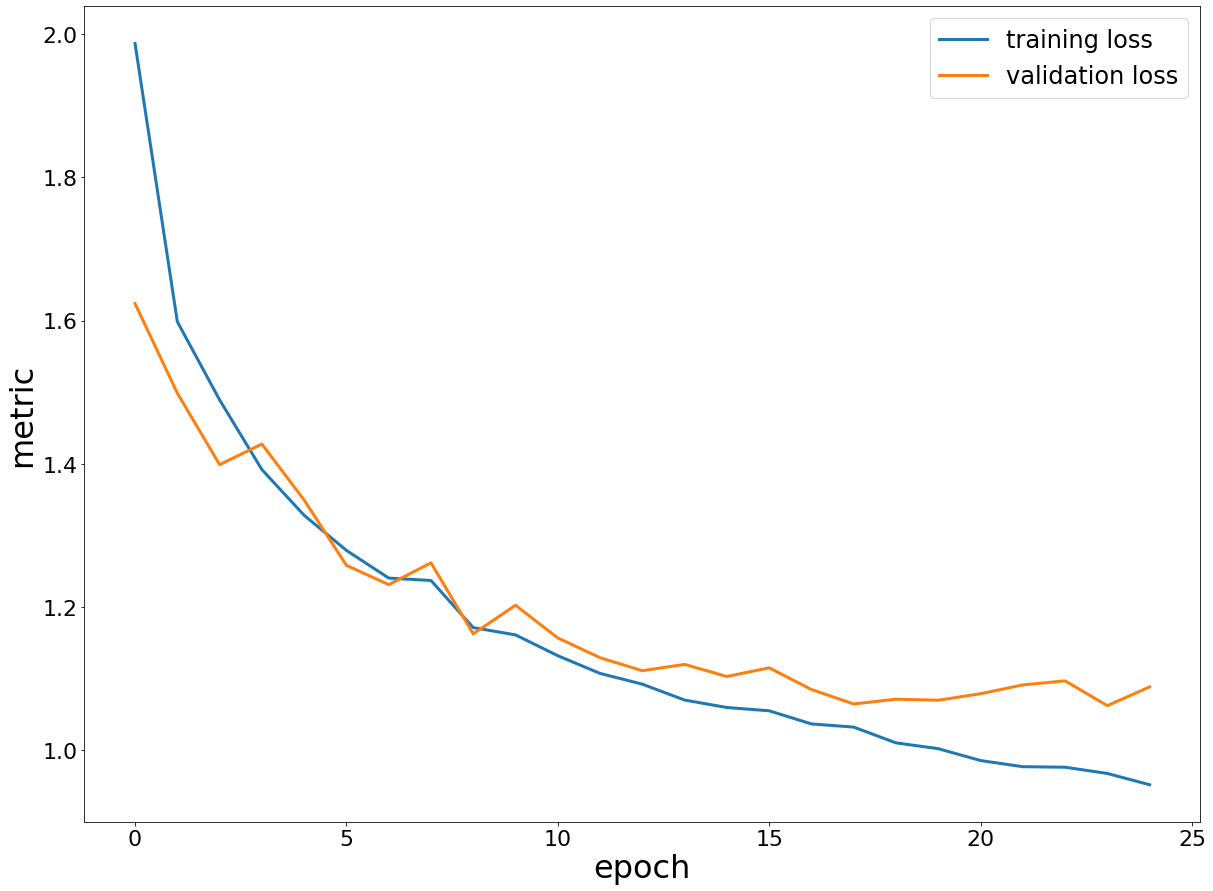

In [15]:
fig = plt.figure(figsize=(20, 15))
plt.xlabel('epoch')
plt.ylabel('metric')

tl = torch.mean(train_losses.reshape([n_epochs, -1]), axis=1).detach().cpu()
vl = val_losses.detach().cpu()
plt.plot(tl, label="training loss")
plt.plot(vl, label="validation loss")

plt.legend()

fig.savefig(f"outputs/stats/pass{vertex_pass}/{view}/stats_loss_{vertex_pass}_{view}.pdf", dpi=200)
fig.savefig(f"outputs/stats/pass{vertex_pass}/{view}/stats_loss_{vertex_pass}_{view}.png", dpi=200, facecolor='w')

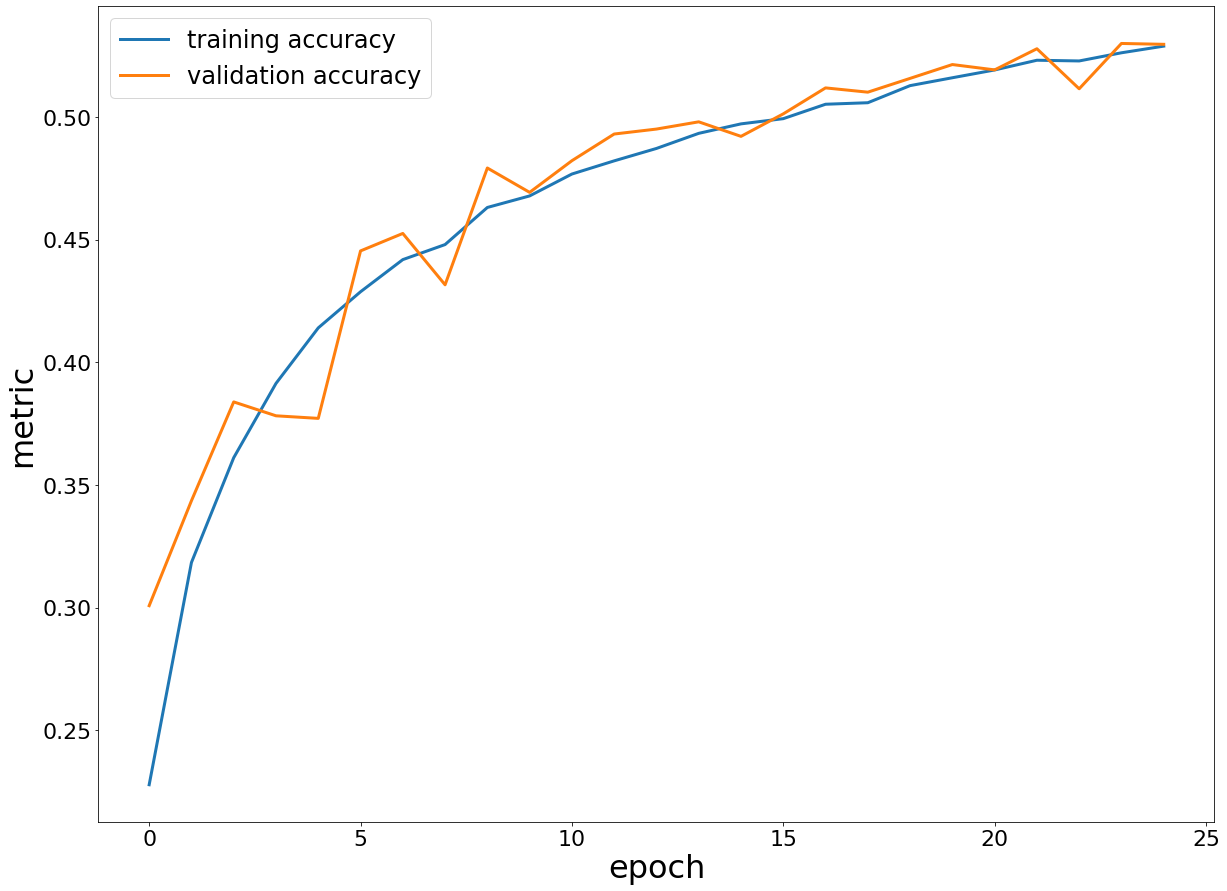

In [16]:
fig = plt.figure(figsize=(20, 15))
plt.xlabel('epoch')
plt.ylabel('metric')

ta = torch.mean(train_accs.reshape([n_epochs, -1]), axis=1).detach().cpu()
va = val_accs.detach().cpu()
plt.plot(ta, label="training accuracy")
plt.plot(va, label="validation accuracy")

plt.legend()

fig.savefig(f"outputs/stats/pass{vertex_pass}/{view}/stats_acc_{vertex_pass}_{view}.pdf", dpi=200)
fig.savefig(f"outputs/stats/pass{vertex_pass}/{view}/stats_acc_{vertex_pass}_{view}.png", dpi=200, facecolor='w')

In [17]:
with open(f'outputs/stats/pass{vertex_pass}/{view}/train_loss_{vertex_pass}_{view}.npy', 'wb') as f:
    np.save(f, tl)
with open(f'outputs/stats/pass{vertex_pass}/{view}/val_loss_{vertex_pass}_{view}.npy', 'wb') as f:
    np.save(f, vl)
with open(f'outputs/stats/pass{vertex_pass}/{view}/train_accs_{vertex_pass}_{view}.npy', 'wb') as f:
    np.save(f, ta)
with open(f'outputs/stats/pass{vertex_pass}/{view}/val_accs_{vertex_pass}_{view}.npy', 'wb') as f:
    np.save(f, va)

# Generating a TorchScript network

The network was trained on a GPU, but ultimately runs on a CPU in a C++ context. This means that the network must be converted to TorchScript format. This can be performed using the cell below and can be run at any time - it need not be run immediately after training the network, because it only requires access to a saved model state.

The only parameters requiring editing here are the location of the input file; which is the save model from the chosen training epoch (so some combination of the <code>moidel_name</code> and epoch with a <code>.pkl</code> extension), the <code>output_filename</code>, which should have a <code>.pt</code> extension, and also the number of classes <code>NUM_CLASSES</code>, which should, of course, match the previouslyt specified value.

The resultant <code>.pt</code> files are what will ultimately be loaded by Pandora for network inference.

In [18]:
# This line is important for ensuring all tensors exist on the same device
torch.set_default_tensor_type(torch.FloatTensor)

filename = f"outputs/models/pass{vertex_pass}/{view}/dunefd_hd_accel_23.pkl"
output_filename = f"PandoraNet_SecVertex_DUNEFD_Accel_{vertex_pass}_{view}.pt"
the_seed = 42
device = torch.device('cpu')
NUM_CLASSES = 20

set_seed(the_seed)

model = load_model_only(filename, NUM_CLASSES, device)

sm = torch.jit.script(model)
sm.save(output_filename)

# Confusion Matrices

In [19]:
# This line is important for GPU running, otherwise some weights end up on the CPU
torch.set_default_tensor_type(torch.cuda.FloatTensor)

the_seed = 42
gpu = torch.device('cuda:0')
batch_size=1
NUM_CLASSES = 20   # NULL = 0, various distance bands 1-19
image_path = f"Accel/Pass{vertex_pass}/Images{view}"

for subdir in ["models", "stats", "images"]:
    dir = f"outputs/{subdir}/pass{vertex_pass}/{view}"
    if not os.path.exists(dir):
        os.makedirs(dir)

set_seed(the_seed)
bunch = SegmentationBunch(image_path, "Hits", "Truth", batch_size=batch_size, valid_pct = 0.25, device=gpu)

filename = f"outputs/models/pass{vertex_pass}/{view}/dunefd_hd_accel_23.pkl"
NUM_CLASSES = 20

set_seed(the_seed)

model = load_model_only(filename, NUM_CLASSES, gpu)

['Image_0.npz' 'Image_1.npz' 'Image_2.npz' ... 'Image_54822.npz'
 'Image_54823.npz' 'Image_54824.npz']


In [20]:
import scipy.stats as stats
binning = np.linspace(0, 20, 21, dtype=int)

model = model.to(gpu)
confusion = np.zeros((20,20))
for img, cls in bunch.valid_dl:
    img = img.to(gpu)
    output = model(img)
    _, preds = torch.max(output, 1)
    
    cls_detached = cls.cpu().numpy().flatten()
    preds_detached = preds.cpu().numpy().flatten()
    
    H, *_ = stats.binned_statistic_2d(preds_detached, cls_detached, None,
                                      bins=[binning, binning], statistic='count')
    confusion += H

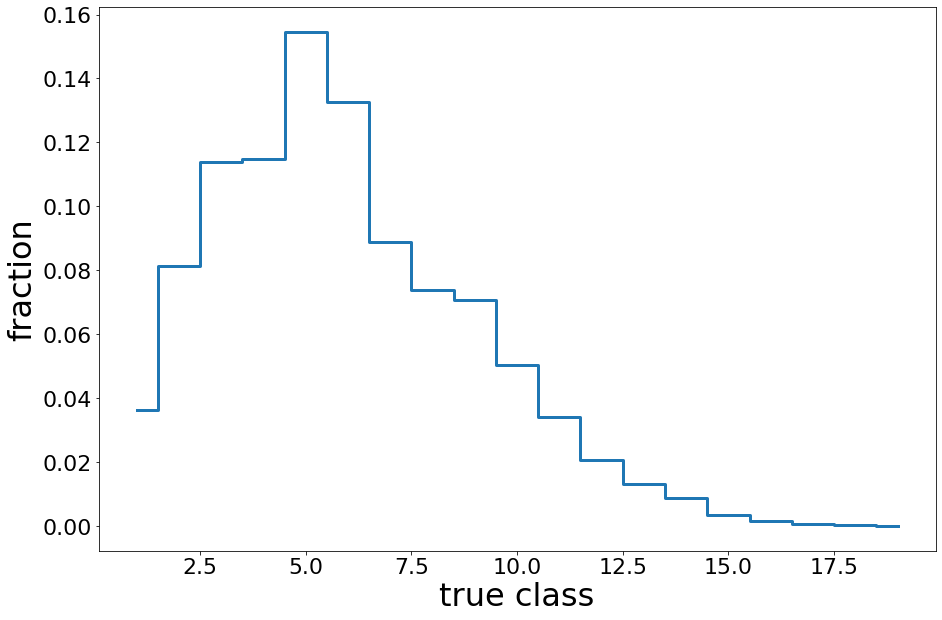

In [21]:
temporary = confusion.copy()
fig = plt.figure(figsize=(15, 10))
plt.xlabel('true class')
plt.ylabel('fraction')
plt.step(list(np.arange(1, 20)), np.sum(temporary[1:], axis=1) / np.sum(temporary[1:]), where="mid")

save_figure(fig, f"outputs/stats/pass{vertex_pass}/{view}/true_class_dist_{vertex_pass}_{view}")

In [22]:
sums = np.sum(confusion, axis=1).repeat(20).reshape((20,20))
confusion /= sums

In [23]:
print(f"--- Class Accuracy")
for t in range(confusion.shape[0]):
    print(f"{t:2}: {100*(confusion[t,t] / confusion[t].sum()):.1f}")
print()

--- Class Accuracy
 0: 100.0
 1: 27.6
 2: 60.5
 3: 62.9
 4: 59.9
 5: 48.0
 6: 45.4
 7: 55.7
 8: 39.8
 9: 60.7
10: 58.8
11: 54.2
12: 47.6
13: 38.0
14: 47.0
15: 48.2
16: 44.2
17: 43.7
18: 42.6
19: 54.2



In [24]:
confusion[0,:] = 0
confusion[:,0] = 0

sums = np.sum(confusion, axis=1).repeat(20).reshape((20,20))
sums[0,:] = 1
confusion /= sums

print(f"--- Class Accuracy")
for t in range(confusion.shape[0]):
    print(f"{t:2}: {100*confusion[t,t]:.1f}")
print()

--- Class Accuracy
 0: 0.0
 1: 27.6
 2: 63.6
 3: 63.2
 4: 60.1
 5: 48.1
 6: 45.4
 7: 55.7
 8: 39.9
 9: 60.9
10: 58.9
11: 54.4
12: 47.8
13: 38.5
14: 47.9
15: 50.8
16: 51.9
17: 51.9
18: 60.6
19: 60.6



0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.28 0.44 0.16 0.07 0.03 0.01 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.04 0.64 0.24 0.06 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.01 0.15 0.63 0.17 0.03 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.05 0.20 0.60 0.11 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.03 0.09 0.24 0.48 0.12 0.03 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.02 0.05 0.10 0.21 0.45 0.14 0.02 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.01 0.02 0.04 0.07 0.19 0.56 0.08 0.03 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.01 0.02 0.04 0.08 0.27 0.40 0.16 0.02 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 
0.00 0.00 0.00 0.01 0.01 0.02 0.03 0.08 0.13 0.61 0.10 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0

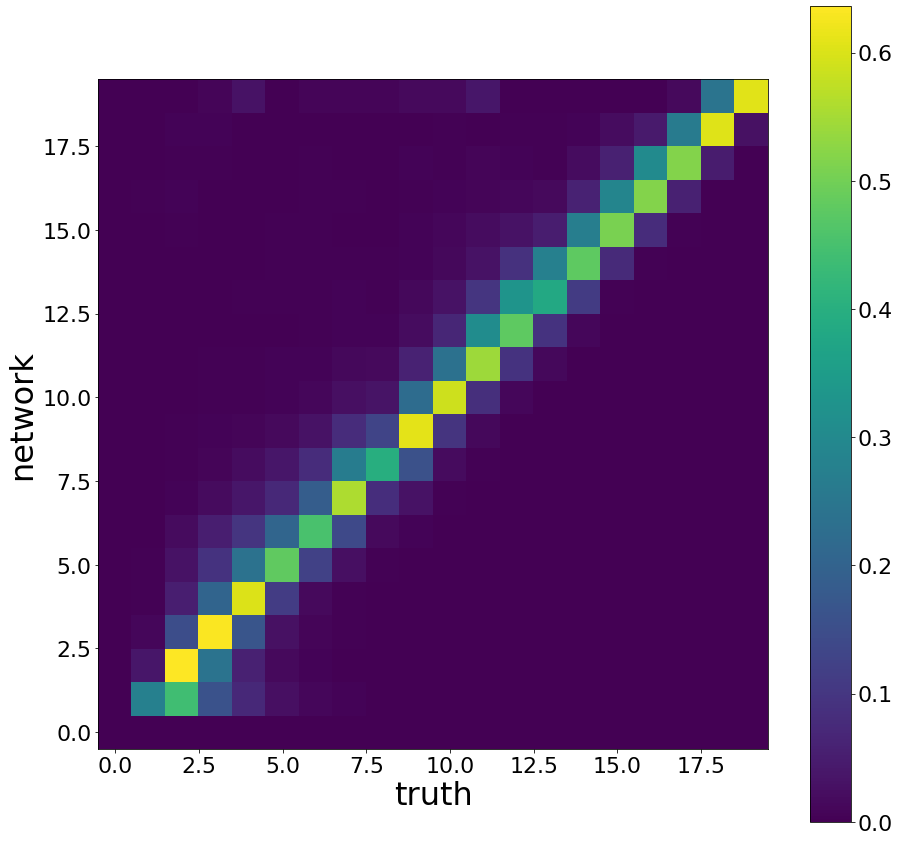

In [25]:
fig = plt.figure(figsize=(15, 15))
plt.xlabel('truth')
plt.ylabel('network')
plt.imshow(confusion)
plt.gca().invert_yaxis()
plt.colorbar()
save_figure(fig, f"outputs/stats/pass{vertex_pass}/{view}/confusion_{vertex_pass}_{view}")

for t in range(20):
    for n in range(20):
        print(f"{confusion[t, n]:.2f}", end=" ")
    print()